In [ ]:
!pip install pillow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import math
from sklearn.metrics import mean_squared_error
from PIL import Image


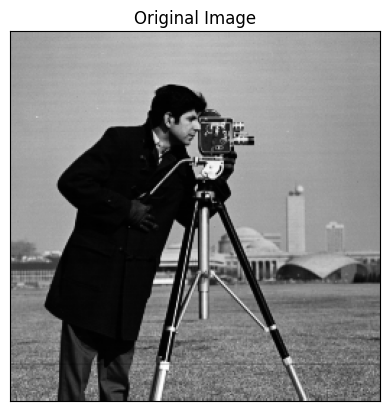

In [ ]:
# Importing Image
image_path = '/content/cameraman.tif'

image = np.array(io.imread(image_path))

plt.imshow(image, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.show()


In [ ]:
# Defining the quantization matrix
# Quality Factor 50
Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quality Factor 80
Q1 = np.array([
    [6, 4, 4, 6, 10, 16, 20, 24],
    [5, 5, 6, 8, 10, 23, 24, 22],
    [6, 5, 6, 10, 16, 23, 28, 22],
    [6, 7, 9, 12, 20, 35, 32, 25],
    [7, 9, 15, 22, 27, 44, 41, 31],
    [10, 14, 22, 26, 32, 42, 45, 37],
    [20, 26, 31, 35, 41, 48, 48, 40],
    [29, 37, 38, 39, 45, 40, 41, 40]
])



#### JPG Compression Code:

In [98]:
class JPG_compute:
  def __init__(self,image,Q_matrix):
    self.image = image # Input image
    self.Q_matrix = Q_matrix # Quantization matrix
    self.height = image.shape[0] # Height of the image
    self.width = image.shape[1] # Width of the image
    self.patch_size = 8 # Size of the patch for compression

  def Compression(self):
    # Initialize the compressed image
    compressed_image = np.zeros(self.image.shape, dtype = 'int')
    # Loop over the image in patches of size self.patch_size
    for i in range(0,self.height,self.patch_size):
      for j in range(0,self.width,self.patch_size):
        # Copy the patch
        patch = self.image[i:i+self.patch_size,j:j+self.patch_size].copy()

        # Normalize the patch and apply DCT
        dct_patch = cv2.dct(patch.astype('float')/255.0) * 255

        # Quantize the DCT coefficients
        Q_patch = np.floor((dct_patch/self.Q_matrix) + 0.5)

        # Store the quantized coefficients in the compressed image
        compressed_image[i:i+self.patch_size,j:j+self.patch_size] = Q_patch
    return compressed_image

  def Decompression(self,compressed_image):
    # Initialize the decompressed image
    decompressed_image = np.zeros(self.image.shape)

    # Loop over the compressed image in patches of size self.patch_size
    for i in range(0,self.height,self.patch_size):
      for j in range(0,self.width,self.patch_size):
        # Copy the patch
        patch = compressed_image[i:i+self.patch_size,j:j+self.patch_size].copy()
        # Reconstruct the DCT coefficients
        Inv_Q_patch = patch*self.Q_matrix
        # Apply IDCT
        idct_patch = cv2.idct(Inv_Q_patch.astype('float'))
        # Store the reconstructed patch in the decompressed image
        decompressed_image[i:i+self.patch_size,j:j+self.patch_size] = idct_patch

    # Clip the values to be in the range [0, 255] and convert to uint8
    decompressed_image = decompressed_image.clip(0, 255).astype('uint8')
    return decompressed_image

  def ravel_function(self,patch):
    raveled_vector = []
    direction = 1

    for idx, val in np.ndenumerate(patch):
        x, y = idx
        if direction == 1:
            if y == 7:
                x += 1
                direction = -1
            elif x == 0:
                y += 1
                direction = -1
            else:
                x -= 1
                y += 1
        else:
            if x == 7:
                y += 1
                direction = 1
            elif y == 0:
                x += 1
                direction = 1
            else:
                x += 1
                y -= 1

        raveled_vector.append(val)

    return(raveled_vector)

  def decimal_to_binary(self,n):
    # Function to convert a decimal number to binary
    return bin(n).replace("0b", "")

  def patch_encoding(self,patch):
    # Function to encode a patch using Huffman coding
    encoded_patch = ''
    flatten_vector = self.ravel_function(patch) # Convert to 1D vector
    for num in flatten_vector:
      if num == 0:
        encoded_patch += '0'
      else:
        # Encode the magnitude of the number
        rep = math.floor(math.log2(abs(num))) + 1
        temp_1 = ('1' * rep) + '0'
        # Encode the sign of the number
        if num < 0: # negative number
          num += 2**(rep) - 1
          temp_2 = self.decimal_to_binary(num)
          temp_2 = ('0' * (rep - len(temp_2))) + temp_2
        else: # positive number
          temp_2 = self.decimal_to_binary(num)
        # Concatenate the magnitude and sign encodings
        temp = temp_1 + temp_2
        encoded_patch += temp
    return encoded_patch

  def image_encoding(self,compressed_image):
    # Function to encode the entire image
    image_encoded_code = ''
    for i in range(0,self.height,self.patch_size):
      for j in range(0,self.width,self.patch_size):
        # Copy the patch
        patch = compressed_image[i:i+self.patch_size,j:j+self.patch_size].copy()
        # Encode the patch
        encoded_patch = self.patch_encoding(patch)
        # Append the encoded patch to the encoded image
        image_encoded_code += encoded_patch
    return image_encoded_code


#### Evaluation:

In [121]:
# Create an instance of the JPG_compute class with the image and quantization matrix
jpg = JPG_compute(image.copy(),Q)

# Compress the image using the Compression method of the JPG_compute class
compressed_image = jpg.Compression()

# Decompress the image using the Decompression method of the JPG_compute class
decompressed_image = jpg.Decompression(compressed_image)

# Encode the compressed image using the image_encoding method of the JPG_compute class
en_code = jpg.image_encoding(compressed_image)

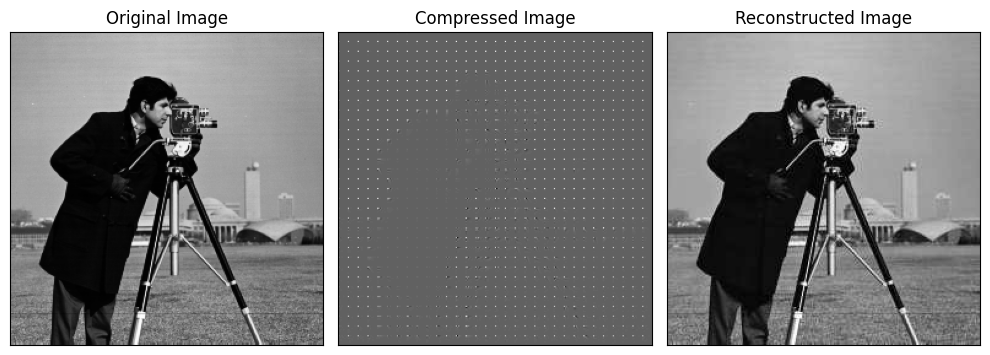

In [122]:
# Display Images:

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(compressed_image, cmap='gray')
plt.title('Compressed Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(decompressed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()


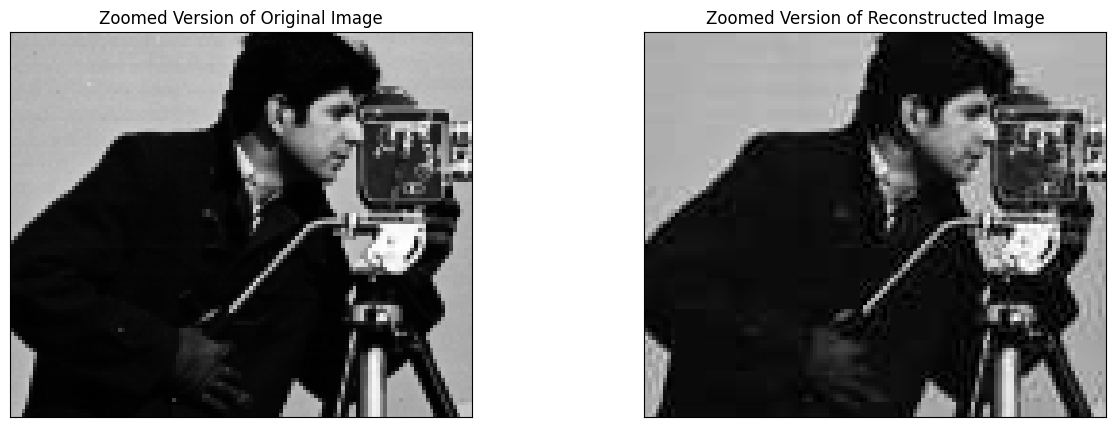

In [123]:
# Zoomed Version of the Images

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].imshow(image[40:140,40:160], cmap = 'gray')
axs[0].set_title("Zoomed Version of Original Image")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(decompressed_image[40:140,40:160], cmap = 'gray')
axs[1].set_title("Zoomed Version of Reconstructed Image")
axs[1].set_xticks([])
axs[1].set_yticks([])
plt.show()

In [124]:
# Calculate MSE:
print(f"Mean squared error: {mean_squared_error(decompressed_image,image):.4f}")
print(f"Size of encoded image: {len(en_code)} bits")
print(f"Size of original image: {image.size * image.itemsize * 8} bits")
print(f"Compression ratio is {((image.size * image.itemsize * 8)/(len(en_code))):.4f}")



Mean squared error: 25.9605
Size of encoded image: 108260 bits
Size of original image: 524288 bits
Compression ratio is 4.8429


#### Library Function:

In [109]:
import io

# Define the desired MSE
mse = mean_squared_error(decompressed_image, image)

def jpeg_compression(image_path,mse):
  # Save the original image with Pillow
  original_image = Image.open(image_path)
  # Save the image with varying JPEG quality to achieve desired MSE
  quality = 100  # Initial quality
  while True:
      buffer = io.BytesIO()
      original_image.save(buffer, format="JPEG", quality=quality)

      buffer.seek(0)
      lib_compressed_image = Image.open(buffer)
      lib_compressed_arr = np.array(lib_compressed_image.convert("L"))
      compressed_mse = mean_squared_error(lib_compressed_arr, image)

      if compressed_mse >= mse:
          break
      quality -= 1
  print(f"Corresponding Quality is {quality}")
  # Get the size of the compressed image
  lib_compressed_size = len(buffer.getvalue()) * 8
  return lib_compressed_image,lib_compressed_size

# Usage:
compressed_lib, lib_compressed_size = jpeg_compression(image_path,mse)

Corresponding Quality is 49


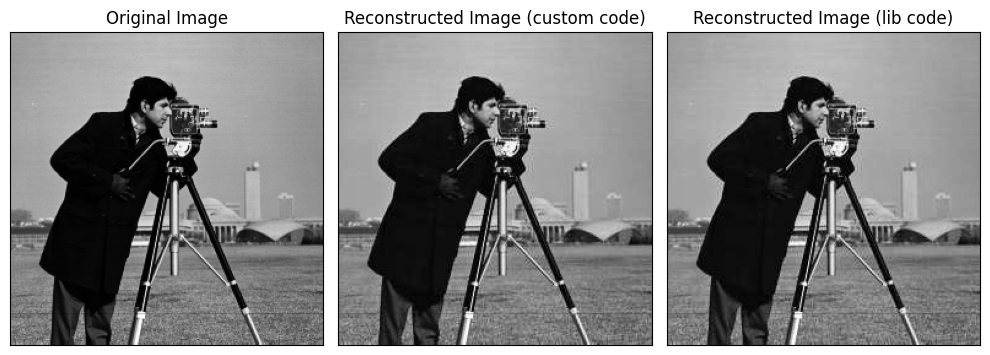

In [110]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(decompressed_image, cmap='gray')
plt.title('Reconstructed Image (custom code)')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(compressed_lib, cmap='gray')
plt.title('Reconstructed Image (lib code)')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()


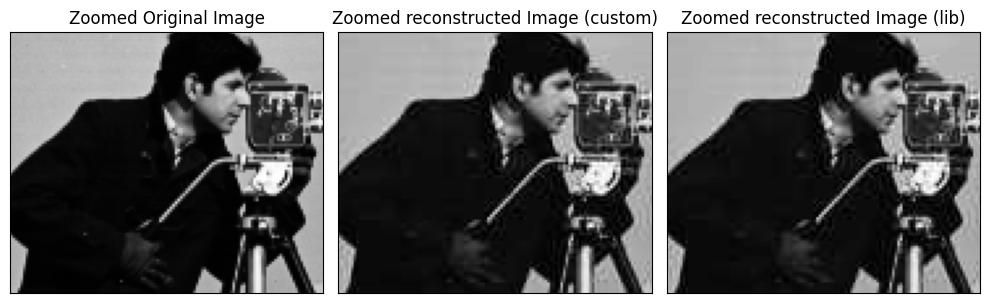

In [111]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image[40:140,40:160], cmap='gray')
plt.title('Zoomed Original Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(decompressed_image[40:140,40:160], cmap='gray')
plt.title('Zoomed reconstructed Image (custom)')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(compressed_lib.crop((40, 40, 160, 140)), cmap='gray')
plt.title('Zoomed reconstructed Image (lib)')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()


In [112]:
# Calculate MSE:
print(f"Mean squared error for custom code: {mean_squared_error(decompressed_image,image):.4f}")
print(f"Mean squared error for in-built code: {mean_squared_error(np.array(compressed_lib),image):.4f}")
print('\n')
print(f"Size of original image: {image.size * image.itemsize * 8} bits")
print(f"Size of encoded image for custom code: {len(en_code)} bits")
print(f"Size of encoded image for built-in code: {lib_compressed_size} bits")
print('\n')
print(f"Compression ratio is {((image.size * image.itemsize * 8)/(len(en_code))):.4f} for custom code.")
print(f"Compression ratio is {((image.size * image.itemsize * 8)/(lib_compressed_size)):.4f} for built-in code.")

Mean squared error for custom code: 25.9605
Mean squared error for in-built code: 25.9923


Size of original image: 524288 bits
Size of encoded image for custom code: 108260 bits
Size of encoded image for built-in code: 56984 bits


Compression ratio is 4.8429 for custom code.
Compression ratio is 9.2006 for built-in code.
